## Loading and preparing data

In [59]:
import json
import pandas as pd
import numpy as np
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

embedding_path = "prompt-sentences-main/prompt_sentences-all-minilm-l6-v2.json"

with open(embedding_path) as f:
    data = json.load(f)
    
positive_values = data["positive_values"]
negative_values = data["negative_values"]

## Functions for converting the dataset into different data formats

In [17]:

def create_dictionary_data(positive_values, index):
    positive_value_dict = {}
    data_frame = None
    for positive_value in positive_values:
        label = positive_value["label"]
        prompts = positive_value["prompts"]
        for prompt in prompts:
            content = prompt["text"]
            embedding = prompt["embedding"]
            for dim in range(len(embedding)):
                positive_value_dict[f"embedding_dim_{dim}"] = embedding[dim]
            positive_value_dict["prompt"] = content
            positive_value_dict["label"] = label
            local_data_frame = pd.DataFrame(positive_value_dict, index=[index])
            if data_frame is None:
                data_frame = pd.concat([local_data_frame])
            else:
                data_frame = pd.concat([data_frame, local_data_frame])
    return data_frame

def build_embedding_data_frame(positive_values, create_dictionary_data):
    index = 0
    dict_data_frame = create_dictionary_data([positive_values[0]], 0)
    embeddings_data_frame = pd.concat([dict_data_frame])
    for positive_value in positive_values:
        index = index + 1
        local_dict_data_frame = create_dictionary_data([positive_value], index)
        embeddings_data_frame = pd.concat([embeddings_data_frame, local_dict_data_frame])
    return embeddings_data_frame
    

## More preparation

In [18]:
dataset = build_embedding_data_frame(positive_values, create_dictionary_data)    
enumerate_label_bijection_map = {}
label_list = dataset["label"]
unique_elements = list(set(label_list))

for i, label in enumerate(unique_elements):
    enumerate_label_bijection_map[f"{i}"] = label
    enumerate_label_bijection_map[label] = f"{i}"
    
columns = [f"embedding_dim_{index}" for index in range(0,384)]
dataset = dataset.reset_index()
dataset = dataset.drop(480).reset_index()
dataset = dataset.sample(frac=1, random_state=42)
X = np.array(dataset[columns])
# X_norm = normalize(X)

In [56]:
dataset.head(2)

,level_0,index,embedding_dim_0,embedding_dim_1,embedding_dim_2,embedding_dim_3,embedding_dim_4,embedding_dim_5,embedding_dim_6,embedding_dim_7,...,embedding_dim_376,embedding_dim_377,embedding_dim_378,embedding_dim_379,embedding_dim_380,embedding_dim_381,embedding_dim_382,embedding_dim_383,prompt,label
408,408,27,-0.091596,-0.003386,0.079718,0.027260,0.04343,0.020433,-0.037500,0.103587,...,-0.004476,0.048916,-0.04422,0.028665,0.110961,-0.063690,-0.071623,-0.002911,Consider the long-term consequences of my requ...,"integrity, compliance, trust, ethics, and dedi..."
97,97,8,0.024302,0.001785,0.027225,0.022263,-0.08224,-0.039377,-0.038973,-0.052871,...,0.002773,-0.043512,-0.06059,0.026621,0.091313,-0.021297,-0.027763,-0.049121,Be consistent in your responses.,commitment


## PCA

In [19]:
pca_X = X
pca = PCA(n_components=3)
pca.fit(pca_X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.06786493 0.05147159 0.04413555]
[6.41777676 5.589149   5.17554612]


## Kmeans

In [66]:
kmeans = KMeans(init="k-means++", n_clusters=57, random_state=42, n_init=25)
kmeans.fit(pca_X)
kmeans_labels = kmeans.labels_

## Kmedoids

In [ ]:
kmedoids = KMedoids(n_clusters=57, random_state=42)
kmedoids.fit(pca_X)
kmedoids_labels = kmedoids.labels_

/Users/tiagomachado/anaconda3/envs/fac/lib/python3.11/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 16 is empty! self.labels_[self.medoid_indices_[16]] may not be labeled with its corresponding cluster (16).
  warnings.warn(


## Utils

In [75]:
def find_nan_indices(arr):
    indices = []
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if np.isnan(arr[i, j]):
                indices.append((i, j))
    return indices

In [ ]:
def convert_array(arr, mapping):
    arr = arr.flatten()
    result = np.array([mapping[str(i)] for i in arr])
    result = result.reshape(arr.shape)
    return result

list_from_pred = (list(convert_array(pred, enumerate_label_bijection_map)))
list_from_dataset = (list(dataset["label"]))

count = 0
for a, b in zip(list_from_pred, list_from_dataset):
    if a == b:
        count = count + 1
    print(a, "--", b)
print(count)

In [51]:

def vizualize_clusters(method, X_data):
    reduced_data = PCA(n_components=2, random_state=42).fit_transform(X_data)
    # kmeans = KMeans(init="k-means++", n_clusters=57, n_init=4)
    method.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
    Z = method.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
    centroids = method.cluster_centers_
    plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=30,
    linewidths=3,
    color="w",
    zorder=10,
)
    plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
    return method, reduced_data

Explained variance ratio:  [0.01953406 0.06477791]


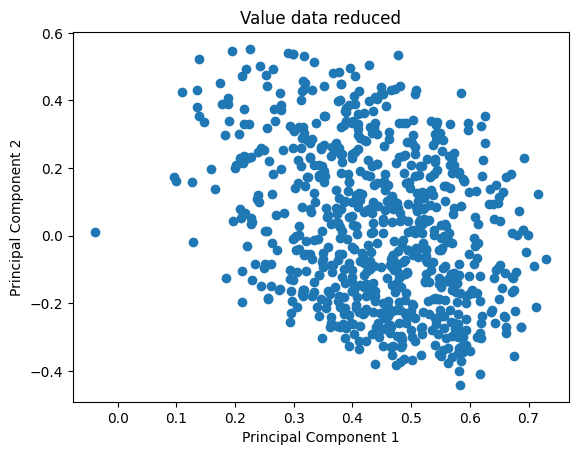

In [ ]:


# Scale the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform SVD
svd = TruncatedSVD(n_components=2)  # retain 2 singular values
X_reduced = svd.fit_transform(X)

# Print explained variance ratio
print("Explained variance ratio: ", svd.explained_variance_ratio_)


plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Value data reduced")
plt.show()

In [58]:
cluster_method, reduced_data = vizualize_clusters(kmeans, X_data=X_scaled)

array([35, 36,  2, 19, 55,  5, 33,  1, 27, 37, 46, 51, 36, 37, 56, 36, 52,
        3, 20, 27, 46, 42, 35, 31,  7, 45, 11, 56, 23, 45, 14, 18,  4,  1,
       41, 15,  2, 42, 38, 54,  4, 33,  9, 12, 10, 47, 30, 21, 34, 48, 42,
       36, 26,  6,  9, 11, 25,  1, 11,  8, 11, 54, 51, 52, 48, 30, 16, 55,
       30, 25, 47,  0, 36, 15, 33,  0, 39, 12, 35, 36, 41, 51, 31, 13, 23,
       24,  2, 36, 37, 16,  5, 43, 33, 11, 15, 54, 10,  9,  3, 51, 14, 17,
       40, 53, 23, 54, 30, 56, 31,  8, 11, 39, 25, 35,  7, 48, 33, 53, 47,
        3, 37, 42, 16, 38, 18, 30, 18,  4, 30,  7,  9, 52, 40, 34,  9, 22,
       22, 15, 35, 15, 52, 46, 29, 11, 50, 53, 15, 40,  0, 30, 31, 22, 48,
       20, 17, 49, 29, 39, 35, 47, 33, 26, 51, 12, 12, 14,  1, 17, 10,  3,
       31, 18, 34,  8, 39, 40, 37, 51, 11, 28, 30, 19, 47, 48, 19, 41, 52,
       35, 48,  3, 20, 51, 36, 33, 14, 45,  1, 31, 11, 15, 30, 19, 21, 11,
       21,  7, 17, 13, 52, 34, 48, 24, 54,  2, 23, 38, 37, 35,  9,  3, 34,
       48,  8, 47, 53,  7